In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
%run '../functions.py'
%run '../classes.py'


model_w2v_settings = return_best_model()
model_w2v_settings = cp.deepcopy(model_w2v_settings)
model_w2v_settings['model_path'] = "../all_datasets/" + model_w2v_settings['model_path']
model_w2v = Word2VecModel(model_w2v_settings)

# read preprocessed data from pickle file
df = pd.read_pickle('data/preprocessed_titles_labels.pkl')
df.head()

In [2]:
# split data into train and test stratified by y
import os
import pickle

df['title_vector'] = [get_word_vectors(model_w2v, title, aggregation='mean') for title in df['title']]

X_train = np.vstack(df[df['sample']=='train']['title_vector'])
X_test = np.vstack(df[df['sample']=='val2']['title_vector'])



y_train = df[df['sample']=='train']['is_clickbait']
y_test = df[df['sample']=='val2']['is_clickbait']


# read scaler from file
with open('predictive_models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/Users/adammajczyk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=[f'dim_{i}' for i in range(X_train_scaled.shape[1])])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=[f'dim_{i}' for i in range(X_test_scaled.shape[1])])

In [5]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

def return_model_with_param(model_name, param = dict()):
    if model_name == 'decision_tree':
        model = DecisionTreeClassifier(**param)
    elif model_name == 'random_forest':
        model = RandomForestClassifier(**param)
    elif model_name == 'xgboost':
        model = XGBClassifier(**param)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**param, verbose=-1)
    elif model_name == 'catboost':
        model = CatBoostClassifier(**param, verbose=0)
    return model

In [ ]:
# train LightGBM model for each dimension


from sklearn.metrics import roc_auc_score, f1_score
from tqdm.notebook import tqdm



result_dict = {}
model_names = ['lightgbm', 'decision_tree',  'xgboost', 'random_forest','catboost',]
for name in model_names:
    result_dict[name] = dict()

models = dict()
for name in model_names:
    models[name] = cp.deepcopy(0)
models['lightgbm'] = 1

for name in tqdm(model_names):
    # for dim in tqdm(X_train_scaled_df.columns):
    #     model = return_model_with_param(name)
    #     model.fit(X_train_scaled_df[dim].values.reshape(-1,1), y_train)

    #     # calculate auc, f1
    #     y_pred_proba = model.predict_proba(X_test_scaled_df[dim].values.reshape(-1,1))[:, 1]
    #     auc = roc_auc_score(y_test, y_pred_proba)

    #     y_pred = model.predict(X_test_scaled_df[dim].values.reshape(-1,1))
    #     f1 = f1_score(y_test, y_pred)
    #     result_dict[name][dim] = {'auc': auc, 'f1': f1}
    model = return_model_with_param(name)

    model.fit(X_train_scaled_df, y_train)
    result_dict[name]['feature_importance'] = model.feature_importances_

    models[name] = cp.deepcopy(model)
result_df = pd.DataFrame(result_dict).T






In [7]:
result_df['feature_importance_mean'] = result_df['feature_importance'].apply(lambda x: np.mean(x))
result_df['feature_importance_std'] = result_df['feature_importance'].apply(lambda x: np.std(x))

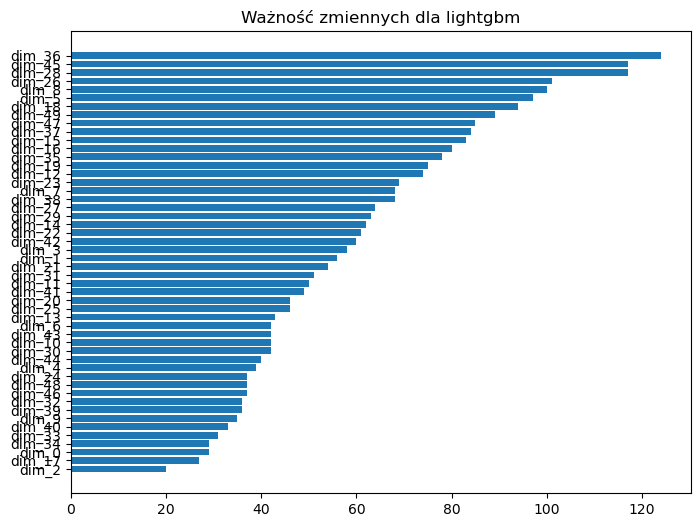

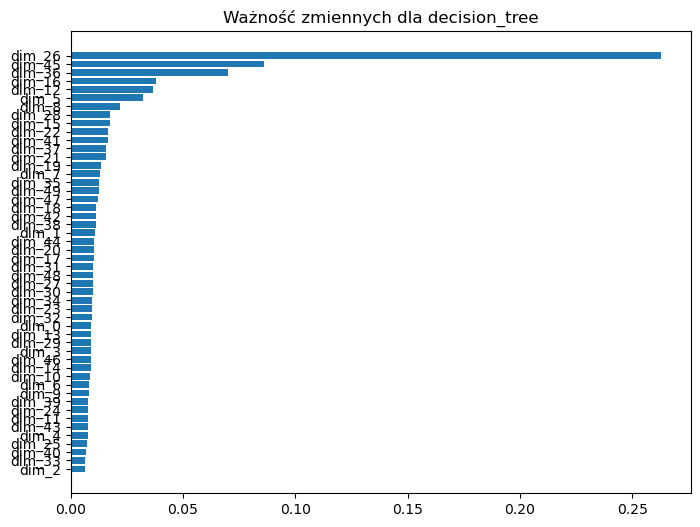

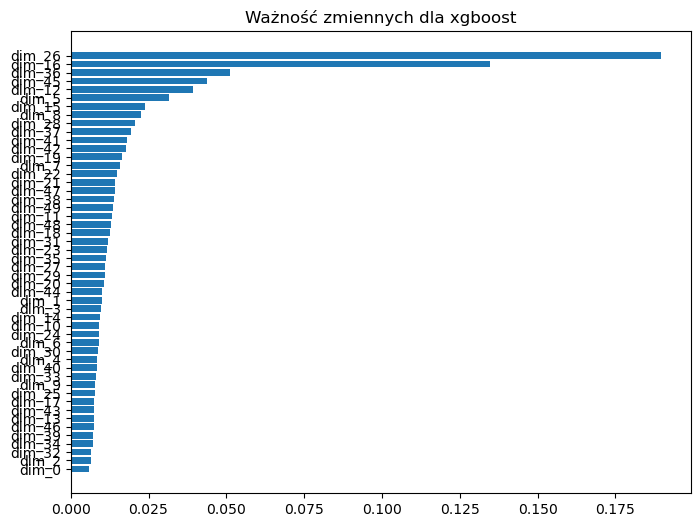

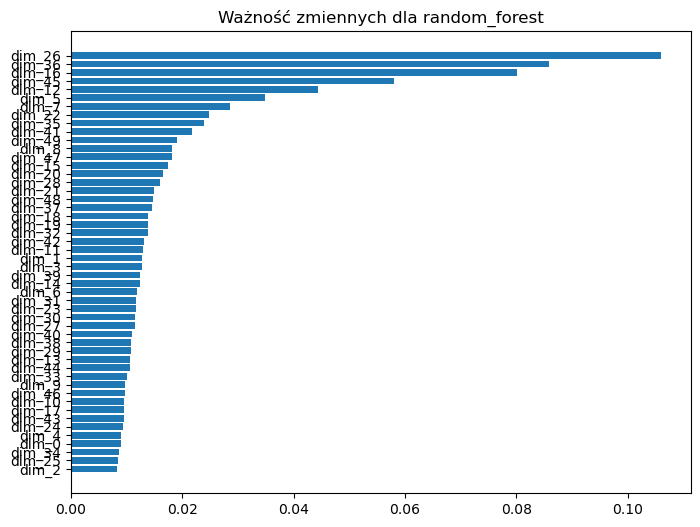

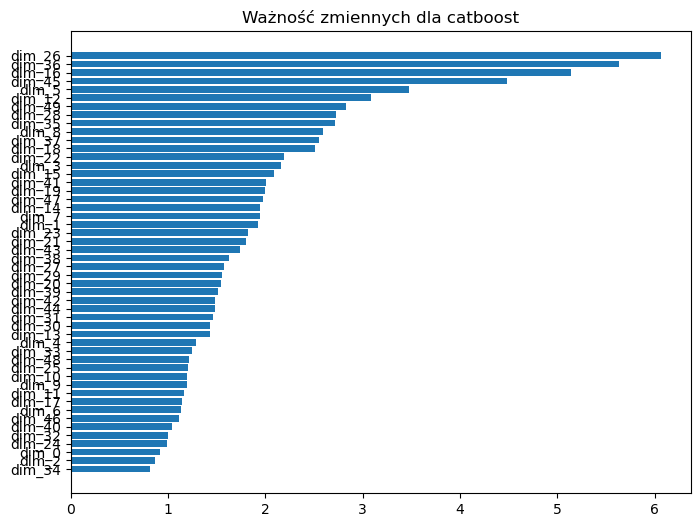

In [8]:
import matplotlib.pyplot as plt
for name in model_names:
    feature_importance = result_df.loc[name]['feature_importance']
    sorted_indices = np.argsort(feature_importance)[::]
    sorted_features = X_train_scaled_df.columns[sorted_indices]
    sorted_importance = feature_importance[sorted_indices]
    
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importance)
    plt.title(f'Ważność zmiennych dla {name}')


In [ ]:
# get 10 worst performing dimensions for each model based on feature importance
import dalex as dx
worst_performing_dimensions = dict()
for name in model_names:
    worst_performing_dimensions[name] = None
for name in model_names:
    explainer = dx.Explainer(models[name], X_train_scaled_df, y_train, verbose=False)
    feature_importance = explainer.model_parts(random_state=42).result
    # print(feature_importance)
    full_model = feature_importance[feature_importance['variable'] == '_full_model_']['dropout_loss'].values[0]
    feature_importance = feature_importance[feature_importance['variable'].str.contains('dim')]
    diff = feature_importance['dropout_loss'] - full_model
    feature_importance['diff'] = diff
    feature_importance = feature_importance.sort_values(by='diff', ascending=False)

    best_performing_dimension_top5percent = feature_importance['diff'].values[:int(len(feature_importance)*0.05)]
    # print(feature_importance)
    # print(best_performing_dimension_top5percent)
    # # break
    best_performing_dimension = np.mean(best_performing_dimension_top5percent)
    # print(best_performing_dimension)
    feature_importance = feature_importance[feature_importance['diff'] < best_performing_dimension/4]
    dropped_dimensions = feature_importance['variable'].values
    worst_performing_dimensions[name] = dropped_dimensions

    
    print(f'Worst performing dimensions for {name}:')
    print(dropped_dimensions, len(dropped_dimensions))

    
worst_performing_dimensions

In [41]:
# get intersection of worst performing dimensions
worst_performing_dimensions_intersection = set(worst_performing_dimensions['lightgbm']).intersection(set(worst_performing_dimensions['decision_tree']), set(worst_performing_dimensions['xgboost']), set(worst_performing_dimensions['random_forest']), set(worst_performing_dimensions['catboost']))
worst_performing_dimensions_intersection, len(worst_performing_dimensions_intersection)

({'dim_0',
  'dim_10',
  'dim_11',
  'dim_17',
  'dim_2',
  'dim_20',
  'dim_22',
  'dim_24',
  'dim_27',
  'dim_30',
  'dim_31',
  'dim_32',
  'dim_33',
  'dim_34',
  'dim_39',
  'dim_40',
  'dim_41',
  'dim_42',
  'dim_46',
  'dim_48',
  'dim_6',
  'dim_7',
  'dim_9'},
 23)

In [42]:
# save which dimensions to remove to file
with open('predictive_models/worst_performing_dimensions_intersection.pkl', 'wb') as f:
    pickle.dump(worst_performing_dimensions_intersection, f)

Text(0, 0.5, 'Prawdopodobieństwo [0, 1]')

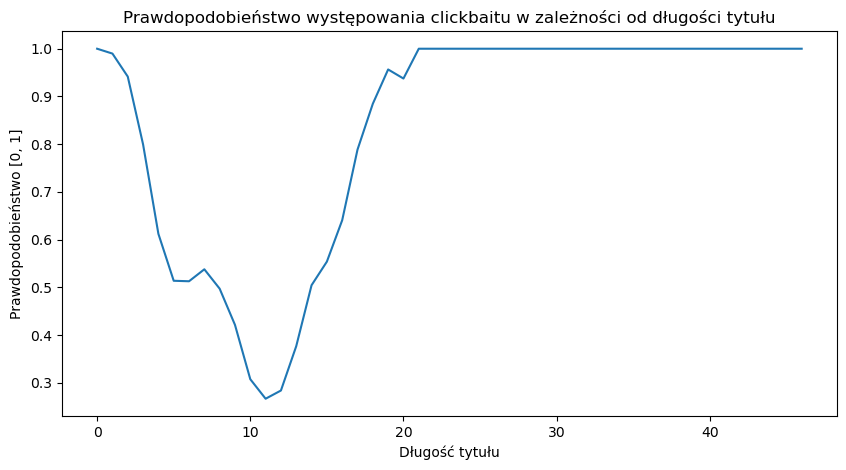

In [43]:
# do we want title length as a feature?
df['title_length'] = df['title'].apply(lambda x: len(x))

df.groupby('title_length')['is_clickbait'].mean().plot( figsize=(10, 5))
plt.title('Prawdopodobieństwo występowania clickbaitu w zależności od długości tytułu')
plt.xlabel('Długość tytułu')
plt.ylabel('Prawdopodobieństwo [0, 1]')